In [97]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline


import sys
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import loompy
import velocyto as vcy
import logging
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
import cytograph as cg
import loompy
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
from tqdm import trange
from types import SimpleNamespace
import pandas as pd
from typing import *

logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)

2018-12-02 12:51:35,774 DEBUG: backend module://ipykernel.pylab.backend_inline version unknown


In [2]:


class LassoRegressionModel(nn.Module):
    def __init__(self, n_inputs: int, n_outputs: int, lr: float = 0.01, l1_weight: float = 1) -> None:
        super(LassoRegressionModel, self).__init__()

        # Parameters
        self.l1_weight = l1_weight

        # The neural network
        self.layer1 = nn.Linear(n_inputs, n_outputs)
        
        # The optimization algorithm
        self.optimiser = torch.optim.SGD(self.parameters(), lr = lr)

    def loss(self, y, y_pred):
        l1_reg = Variable(torch.FloatTensor(1), requires_grad=True)
        for W in self.parameters():
            l1_reg = l1_reg + W.norm(1)
        return nn.MSELoss()(y, y_pred) + self.l1_weight * l1_reg

    def forward(self, x):
        y = self.layer1(x)
        return y


class LinearRegressionModel(nn.Module):
    def __init__(self, n_inputs: int, n_outputs: int, lr: float = 0.01) -> None:
        super(LinearRegressionModel, self).__init__()

        # The neural network
        self.layer1 = nn.Linear(n_inputs, n_outputs)

        # The optimization algorithm
        self.optimiser = torch.optim.SGD(self.parameters(), lr = lr)

    def loss(self, y, y_pred):
        return nn.MSELoss()(y, y_pred)

    def forward(self, x):
        y = self.layer1(x)
        return y

class WaddingtonianDataset:
    def __init__(self, ds: loompy.LoomConnection) -> None:
        human_TFs = pd.read_csv("/Users/stelin/code/development-human/TFs_human.txt", sep="\t").values.T[0]
        self.n_cells = ds.shape[1]
        self.regulators = np.isin(ds.ra.Gene, human_TFs)
        self.regulator_names = ds.ra.Gene[self.regulators]
        self.n_regulators = self.regulators.sum()
        self.targets = ds.ra.Selected == 1
        self.target_names = ds.ra.Gene[self.targets]
        self.n_targets = self.targets.sum()

        # Load the velocity data for all selected genes
        v_data = np.empty((self.n_targets, self.n_cells), dtype='float32')
        r = 0
        for (_, _, view) in ds.scan(items=self.targets, axis=0, layers=["spliced_exp", "velocity"]):
            v_data[r:r + view.shape[0], :] = view.layers["velocity"][:, :]
            r += view.shape[0]
        self.v = torch.from_numpy(v_data.T)

        # Load the expression data for TFs only
        s_data = np.empty((self.n_regulators, self.n_cells), dtype='float32')
        r = 0
        for (_, _, view) in ds.scan(items=self.regulators, axis=0, layers=["spliced_exp", "velocity"]):
            s_data[r:r + view.shape[0], :] = view.layers["spliced_exp"][:, :]
            r += view.shape[0]
        self.s = torch.from_numpy(s_data.T)
        
class WaddingtonianInference:
    def __init__(self, dataset: WaddingtonianDataset, model_type: nn.Module = LinearRegressionModel, lr: float = 0.001, n_epochs: int = 100, **kwargs) -> None:
        self.dataset = dataset
        self.model_type = model_type
        self.model: nn.Module = None
        self.model_kwargs = kwargs
        self.lr = lr
        self.n_epochs = n_epochs
        self.losses: List[float] = []

    def fit(self) -> None:
        self.model = self.model_type(self.dataset.n_regulators, self.dataset.n_targets, self.lr, **self.model_kwargs)

        t = trange(self.n_epochs)
        for epoch in t:
            self.model.optimiser.zero_grad()

            x = Variable(self.dataset.s)
            y = Variable(self.dataset.v)

            y_pred = self.model.forward(x)
            loss = self.model.loss(y, y_pred)
            self.losses.append(float(loss))
            loss.backward()
            self.model.optimiser.step()
            t.set_description(f"loss={float(loss)}")
            t.refresh()

In [3]:
with loompy.connect("/Users/stelin/dh_20170213/L1_Cortex_11w.loom") as ds:
    wdata = WaddingtonianDataset(ds)

In [4]:
wi = WaddingtonianInference(wdata, model_type=LinearRegressionModel, lr=0.0001, n_epochs=500)
wi.fit()

loss=854.996826171875: 100%|██████████| 500/500 [05:41<00:00,  1.41it/s]


2018-12-01 21:52:58,268 DEBUG: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/stelin/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


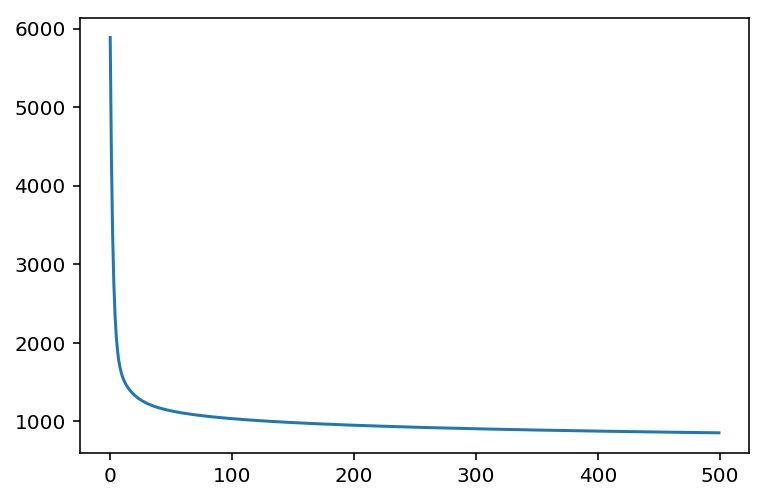

In [5]:
_=plt.plot(np.arange(len(wi.losses)), wi.losses)

In [16]:
#np.argmax(wi.model.layer1.weight.detach().numpy(), axis=1)
weights = wi.model.layer1.weight.detach().numpy()
indices = np.where(weights > 0.025)
print(np.unique(wdata.regulator_names[indices[1]]))
#print(np.unique(wdata.targets[indices[0]]))
#print(np.sort(wdata.target_names[(weights[:, wdata.regulator_names == "SOX2"] < -0.0001).T[0]]))

['AEBP1' 'AFF1' 'AFF3' 'AFF4' 'ARID3A' 'ASCL1' 'BARHL2' 'BCL11B' 'BHLHE22'
 'BHLHE40' 'BHLHE41' 'CEBPB' 'CEBPD' 'CREB3L2' 'CREB5' 'CREM' 'CSRNP1'
 'CUX1' 'DACH1' 'DEAF1' 'DLX1' 'DLX2' 'DLX5' 'DNAJC1' 'E2F8' 'EBF1' 'EBF3'
 'EGR1' 'EGR2' 'EGR3' 'ELF1' 'ELK3' 'EMX2' 'EOMES' 'EPAS1' 'ERG' 'ETS1'
 'ETS2' 'ETV6' 'FEZF2' 'FLI1' 'FOS' 'FOSB' 'FOSL2' 'FOXC1' 'FOXF2' 'FOXJ1'
 'FOXL2' 'FOXO1' 'FOXP1' 'FOXP2' 'FOXQ1' 'FOXS1' 'GATA2' 'GLI3' 'HES1'
 'HES4' 'HES6' 'HEYL' 'HHEX' 'HIC1' 'HLX' 'HMGA2' 'HOPX' 'ID1' 'ID2' 'ID3'
 'ID4' 'IFI16' 'INSM1' 'IRF1' 'IRF8' 'JARID2' 'JUN' 'JUNB' 'KLF10' 'KLF12'
 'KLF2' 'KLF3' 'KLF4' 'KLF6' 'KLF7' 'LCORL' 'LEF1' 'LHX1' 'LHX5' 'LHX6'
 'LHX9' 'LYL1' 'MAF' 'MAFF' 'MAFK' 'MBD2' 'MECOM' 'MEF2A' 'MEF2C' 'MEF2D'
 'MIS18BP1' 'MLLT3' 'MSX1' 'MSX2' 'MXD4' 'MYT1L' 'NEUROD2' 'NEUROD4'
 'NEUROD6' 'NEUROG1' 'NFKB1' 'NFKBIA' 'NFKBID' 'NHLH1' 'NHLH2' 'NPAS3'
 'NR2E1' 'NR2F2' 'NR3C1' 'NR4A1' 'NR4A2' 'PAWR' 'PAX6' 'PBX2' 'PCBP3'
 'PLEK' 'PPARD' 'PRDM1' 'RARA' 'RARG' 'RBPJ' 'RELB' 'RE

['GRIK2' 'KIAA1467' 'IGFBP5' 'NEGR1' 'CNTN5' 'VSNL1' 'KCNJ6' 'CBLN4'
 'LMO3' 'CDH13']


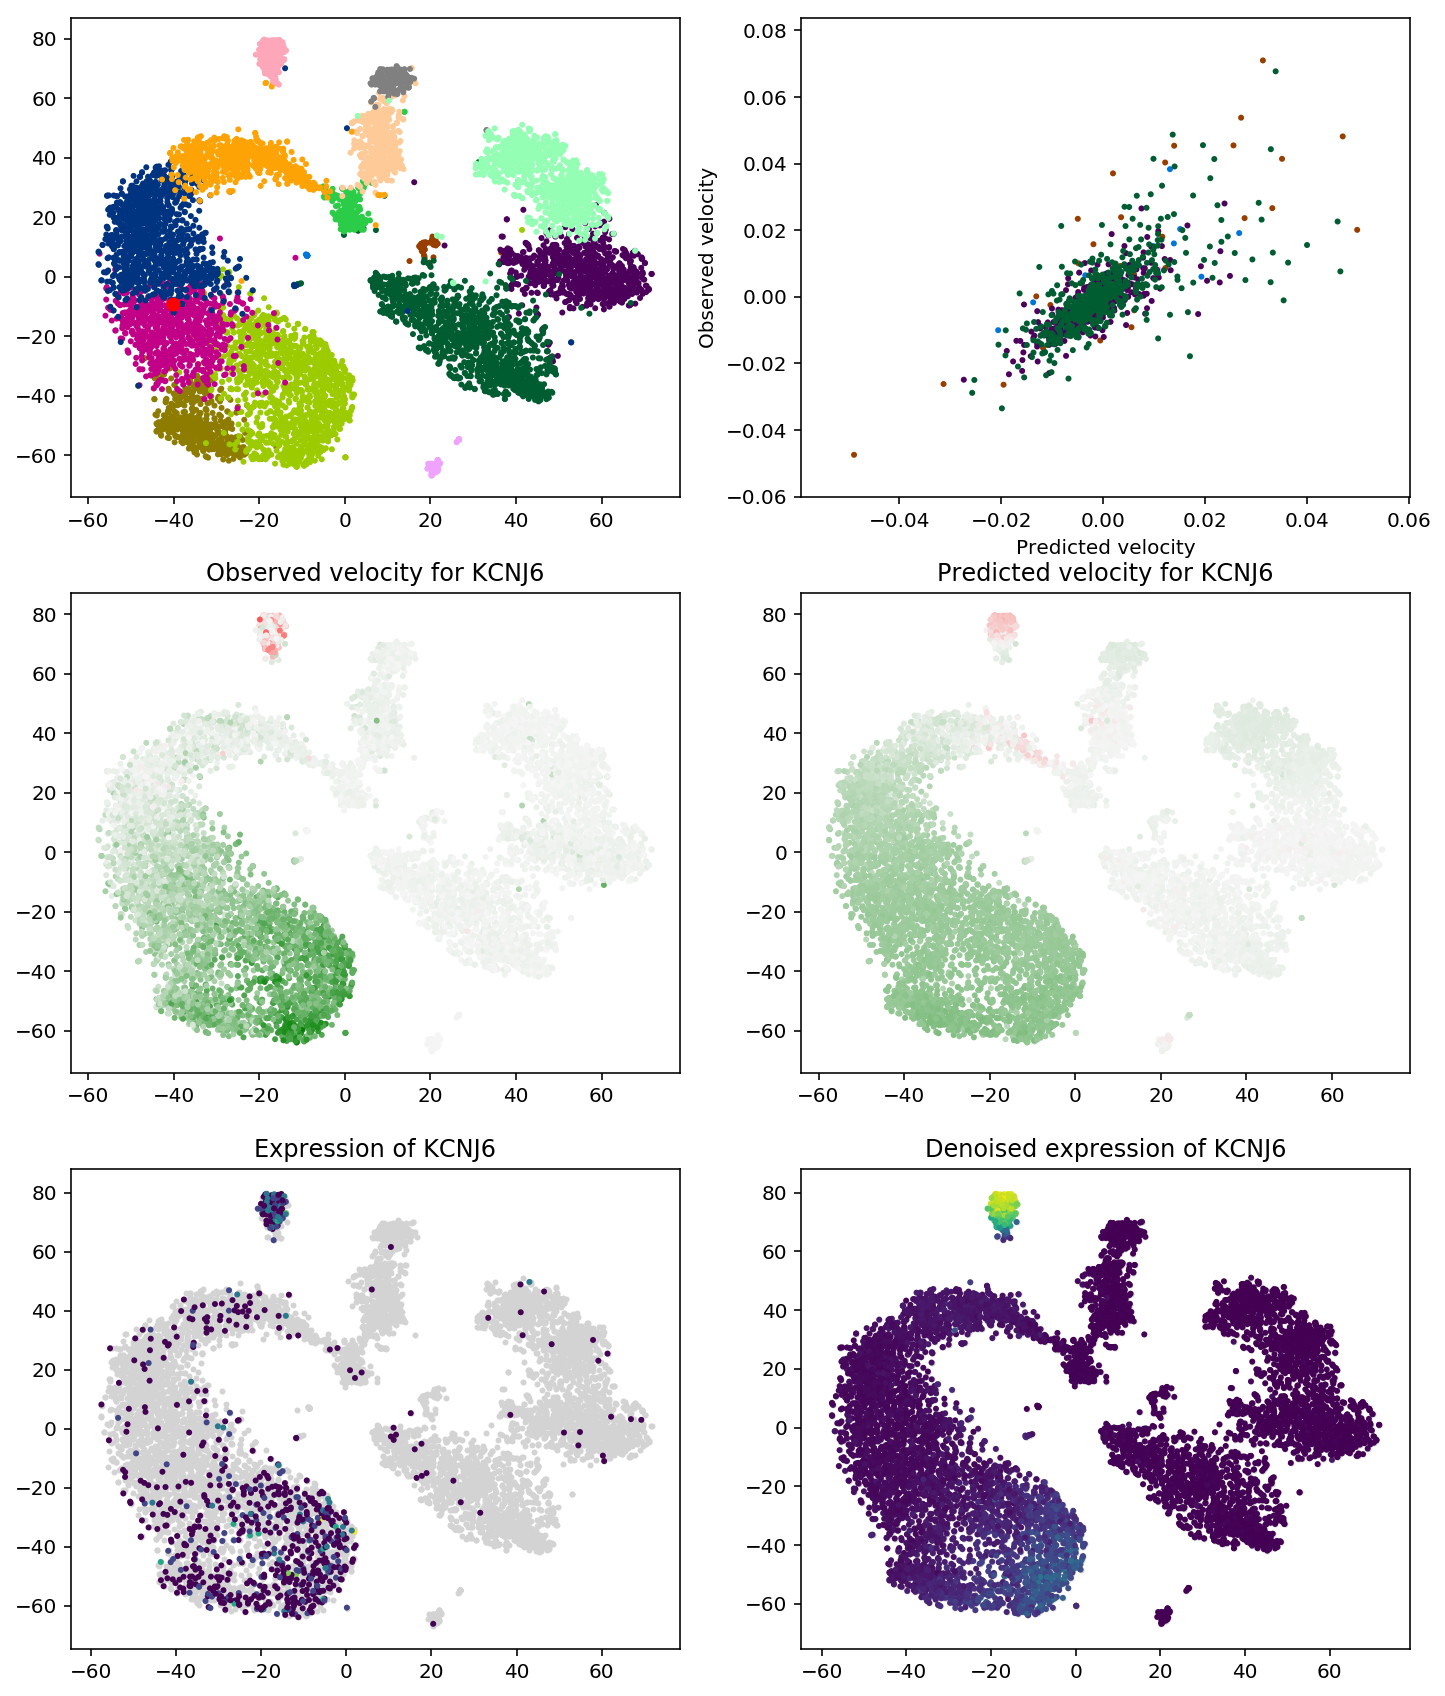

In [96]:
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
norm = MidpointNormalize(midpoint=0)
vcmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","whitesmoke","green"])


with loompy.connect("/Users/stelin/dh_20170213/L1_Cortex_11w.loom") as ds:
    ix = 6191
    plt.figure(figsize=(12,15))
    plt.subplot(321)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c=cg.colorize(ds.ca.Clusters), marker='.',lw=0)
    plt.plot(ds.ca.TSNE[ix,0], ds.ca.TSNE[ix,1],c='red',marker='o')
    plt.subplot(322)
    s = wdata.s.detach().numpy()
    v = wdata.v.detach().numpy()
    y_pred = wi.model.forward(Variable(torch.from_numpy(s))).detach().numpy()

    plt.scatter(y_pred[ix, :], v[ix, :],c=cg.colorize(ds.ca.Clusters), marker='.',lw=0)
    plt.ylabel("Observed velocity")
    plt.xlabel("Predicted velocity")
    print(wdata.target_names[np.argsort(y_pred[ix, :])[-10:]])
    
    top_idx = -4

    plt.subplot(323)
    top = np.argsort(y_pred[ix, :])[top_idx]
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c=v[:, top], norm=norm, cmap=vcmap, marker='.',lw=0)
    plt.title("Observed velocity for " + wdata.target_names[top])
        
    plt.subplot(324)
    top = np.argsort(y_pred[ix, :])[top_idx]
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c=y_pred[:, top],norm=norm, cmap=vcmap, marker='.',lw=0)
    plt.title("Predicted velocity for " + wdata.target_names[top])

    plt.subplot(325)
    top = np.argsort(y_pred[ix, :])[top_idx]
    x = ds[ds.ra.Gene == wdata.target_names[top], :][0]
    cells = x > 0
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c='lightgrey', marker='.',lw=0)
    plt.scatter(ds.ca.TSNE[cells,0], ds.ca.TSNE[cells,1],c=x[cells], marker='.',lw=0)
    plt.title("Expression of " + wdata.target_names[top])

    plt.subplot(326)
    top = np.argsort(y_pred[ix, :])[top_idx]
    x = ds["spliced_exp"][ds.ra.Gene == wdata.target_names[top], :][0]
    cells = x > 0
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c='lightgrey', marker='.',lw=0)
    plt.scatter(ds.ca.TSNE[cells,0], ds.ca.TSNE[cells,1],c=x[cells], marker='.',lw=0)
    plt.title("Denoised expression of " + wdata.target_names[top])




In [72]:
y_pred.shape







(8580, 2005)

In [76]:
top

array([ 105, 1789, 1931, ...,  292,  109,   95])

In [77]:
np.argsort(y_pred[ix, :])[-1]

1729

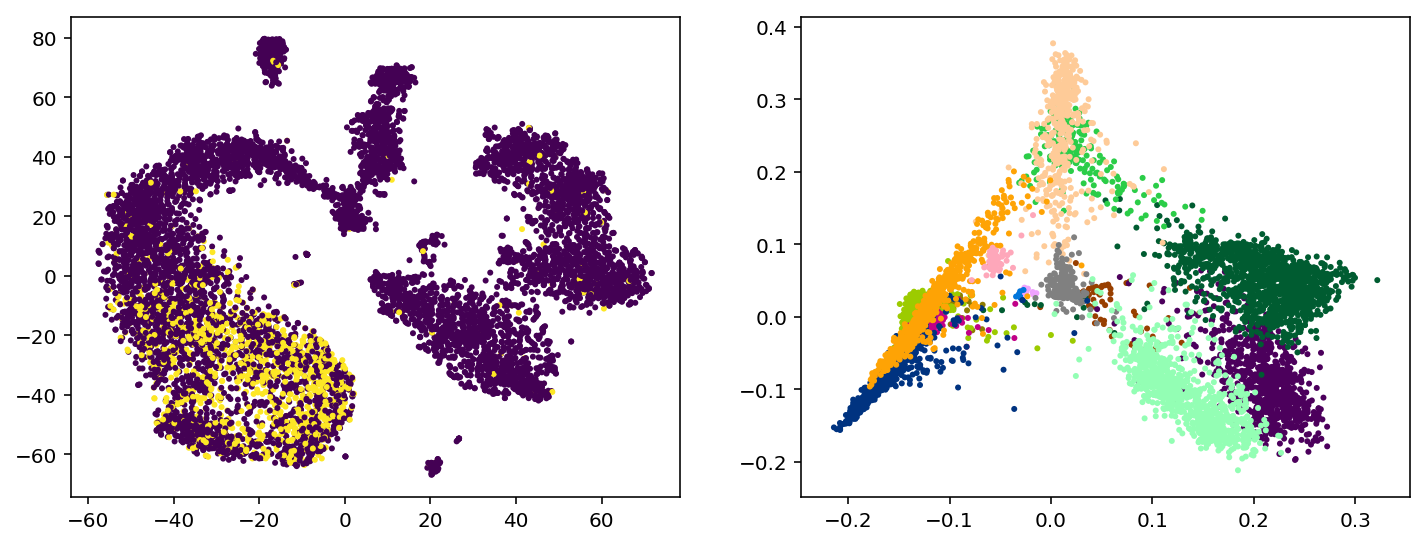

In [216]:
with loompy.connect("/Users/stelin/dh_20170213/L1_Cortex_11w.loom") as ds:
    pca = PCA(n_components=5).fit_transform(ds.ca.HPF)
    plt.figure(figsize=(12,15))
    plt.subplot(321)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c=ds[ds.ra.Gene == "GRIK3", :][0] > 0, marker='.',lw=0)
    plt.subplot(322)
    plt.scatter(pca[:,0], pca[:,3],c=cg.colorize(ds.ca.Clusters), marker='.',lw=0)